# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3588096/11490434 [========>.....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:57 - loss: 0.6938

  28/1875 [..............................] - ETA: 3s - loss: 0.5519   

  60/1875 [..............................] - ETA: 3s - loss: 0.4634

  95/1875 [>.............................] - ETA: 2s - loss: 0.4162

 131/1875 [=>............................] - ETA: 2s - loss: 0.3869

 167/1875 [=>............................] - ETA: 2s - loss: 0.3663

 203/1875 [==>...........................] - ETA: 2s - loss: 0.3505

 231/1875 [==>...........................] - ETA: 2s - loss: 0.3404

 264/1875 [===>..........................] - ETA: 2s - loss: 0.3301

 299/1875 [===>..........................] - ETA: 2s - loss: 0.3206

 329/1875 [====>.........................] - ETA: 2s - loss: 0.3135

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3081

 382/1875 [=====>........................] - ETA: 2s - loss: 0.3026

 410/1875 [=====>........................] - ETA: 2s - loss: 0.2975

 439/1875 [======>.......................] - ETA: 2s - loss: 0.2927

 468/1875 [======>.......................] - ETA: 2s - loss: 0.2882

 497/1875 [======>.......................] - ETA: 2s - loss: 0.2840

 528/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 561/1875 [=======>......................] - ETA: 2s - loss: 0.2757

 594/1875 [========>.....................] - ETA: 2s - loss: 0.2718

 618/1875 [========>.....................] - ETA: 2s - loss: 0.2692

 645/1875 [=========>....................] - ETA: 2s - loss: 0.2663

 677/1875 [=========>....................] - ETA: 1s - loss: 0.2631

 704/1875 [==========>...................] - ETA: 1s - loss: 0.2606

 731/1875 [==========>...................] - ETA: 1s - loss: 0.2581

 757/1875 [===========>..................] - ETA: 1s - loss: 0.2558

 784/1875 [===========>..................] - ETA: 1s - loss: 0.2536

 812/1875 [===========>..................] - ETA: 1s - loss: 0.2514

 839/1875 [============>.................] - ETA: 1s - loss: 0.2493

 871/1875 [============>.................] - ETA: 1s - loss: 0.2469

 904/1875 [=============>................] - ETA: 1s - loss: 0.2446

 931/1875 [=============>................] - ETA: 1s - loss: 0.2428

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2405

1004/1875 [===============>..............] - ETA: 1s - loss: 0.2381

1041/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1070/1875 [================>.............] - ETA: 1s - loss: 0.2342

1100/1875 [================>.............] - ETA: 1s - loss: 0.2326

1135/1875 [=================>............] - ETA: 1s - loss: 0.2307

1174/1875 [=================>............] - ETA: 1s - loss: 0.2287

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2268

1245/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1275/1875 [===================>..........] - ETA: 0s - loss: 0.2239

1309/1875 [===================>..........] - ETA: 0s - loss: 0.2223

1348/1875 [====================>.........] - ETA: 0s - loss: 0.2206

1385/1875 [=====================>........] - ETA: 0s - loss: 0.2191

1423/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2161

1495/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1554/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1584/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1613/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1642/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1671/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1700/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1730/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1783/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1840/1875 [============================>.] - ETA: 0s - loss: 0.2034

1869/1875 [============================>.] - ETA: 0s - loss: 0.2026

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1030

  23/1875 [..............................] - ETA: 4s - loss: 0.1061

  46/1875 [..............................] - ETA: 4s - loss: 0.1069

  72/1875 [>.............................] - ETA: 3s - loss: 0.1071

 100/1875 [>.............................] - ETA: 3s - loss: 0.1073

 130/1875 [=>............................] - ETA: 3s - loss: 0.1075

 156/1875 [=>............................] - ETA: 3s - loss: 0.1077

 183/1875 [=>............................] - ETA: 3s - loss: 0.1077

 212/1875 [==>...........................] - ETA: 3s - loss: 0.1077

 240/1875 [==>...........................] - ETA: 3s - loss: 0.1076

 265/1875 [===>..........................] - ETA: 3s - loss: 0.1076

 292/1875 [===>..........................] - ETA: 3s - loss: 0.1076

 321/1875 [====>.........................] - ETA: 2s - loss: 0.1076

 349/1875 [====>.........................] - ETA: 2s - loss: 0.1075

 379/1875 [=====>........................] - ETA: 2s - loss: 0.1075

 407/1875 [=====>........................] - ETA: 2s - loss: 0.1075

 436/1875 [=====>........................] - ETA: 2s - loss: 0.1074

 464/1875 [======>.......................] - ETA: 2s - loss: 0.1074

 494/1875 [======>.......................] - ETA: 2s - loss: 0.1073

 521/1875 [=======>......................] - ETA: 2s - loss: 0.1073

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1072

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1072

 606/1875 [========>.....................] - ETA: 2s - loss: 0.1071

 634/1875 [=========>....................] - ETA: 2s - loss: 0.1071

 663/1875 [=========>....................] - ETA: 2s - loss: 0.1070

 692/1875 [==========>...................] - ETA: 2s - loss: 0.1069

 720/1875 [==========>...................] - ETA: 2s - loss: 0.1069

 749/1875 [==========>...................] - ETA: 2s - loss: 0.1068

 778/1875 [===========>..................] - ETA: 2s - loss: 0.1068

 807/1875 [===========>..................] - ETA: 1s - loss: 0.1067

 836/1875 [============>.................] - ETA: 1s - loss: 0.1067

 864/1875 [============>.................] - ETA: 1s - loss: 0.1066

 893/1875 [=============>................] - ETA: 1s - loss: 0.1066

 922/1875 [=============>................] - ETA: 1s - loss: 0.1065

 952/1875 [==============>...............] - ETA: 1s - loss: 0.1064

 981/1875 [==============>...............] - ETA: 1s - loss: 0.1064

1005/1875 [===============>..............] - ETA: 1s - loss: 0.1063

1035/1875 [===============>..............] - ETA: 1s - loss: 0.1063

1063/1875 [================>.............] - ETA: 1s - loss: 0.1062

1092/1875 [================>.............] - ETA: 1s - loss: 0.1062

1117/1875 [================>.............] - ETA: 1s - loss: 0.1061

1142/1875 [=================>............] - ETA: 1s - loss: 0.1061

1170/1875 [=================>............] - ETA: 1s - loss: 0.1060

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1060

1228/1875 [==================>...........] - ETA: 1s - loss: 0.1059

1258/1875 [===================>..........] - ETA: 1s - loss: 0.1059

1283/1875 [===================>..........] - ETA: 1s - loss: 0.1058

1313/1875 [====================>.........] - ETA: 1s - loss: 0.1058

1343/1875 [====================>.........] - ETA: 0s - loss: 0.1057

1373/1875 [====================>.........] - ETA: 0s - loss: 0.1057

1403/1875 [=====================>........] - ETA: 0s - loss: 0.1056

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1056

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1055

1490/1875 [======================>.......] - ETA: 0s - loss: 0.1055

1520/1875 [=======================>......] - ETA: 0s - loss: 0.1054

1550/1875 [=======================>......] - ETA: 0s - loss: 0.1054

1580/1875 [========================>.....] - ETA: 0s - loss: 0.1053

1610/1875 [========================>.....] - ETA: 0s - loss: 0.1053

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1052

1669/1875 [=========================>....] - ETA: 0s - loss: 0.1052

1699/1875 [==========================>...] - ETA: 0s - loss: 0.1051

1729/1875 [==========================>...] - ETA: 0s - loss: 0.1051

1760/1875 [===========================>..] - ETA: 0s - loss: 0.1050

1789/1875 [===========================>..] - ETA: 0s - loss: 0.1050

1818/1875 [============================>.] - ETA: 0s - loss: 0.1049

1847/1875 [============================>.] - ETA: 0s - loss: 0.1049

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1048


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1037

  31/1875 [..............................] - ETA: 3s - loss: 0.0961

  61/1875 [..............................] - ETA: 3s - loss: 0.0969

  91/1875 [>.............................] - ETA: 3s - loss: 0.0973

 121/1875 [>.............................] - ETA: 2s - loss: 0.0975

 151/1875 [=>............................] - ETA: 2s - loss: 0.0976

 181/1875 [=>............................] - ETA: 2s - loss: 0.0977

 209/1875 [==>...........................] - ETA: 2s - loss: 0.0978

 235/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 265/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 294/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 353/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 736/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 822/1875 [============>.................] - ETA: 1s - loss: 0.0978

 849/1875 [============>.................] - ETA: 1s - loss: 0.0978

 873/1875 [============>.................] - ETA: 1s - loss: 0.0978

 898/1875 [=============>................] - ETA: 1s - loss: 0.0978

 926/1875 [=============>................] - ETA: 1s - loss: 0.0977

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0977

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0977

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1070/1875 [================>.............] - ETA: 1s - loss: 0.0977

1102/1875 [================>.............] - ETA: 1s - loss: 0.0977

1130/1875 [=================>............] - ETA: 1s - loss: 0.0976

1156/1875 [=================>............] - ETA: 1s - loss: 0.0976

1185/1875 [=================>............] - ETA: 1s - loss: 0.0976

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1270/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1327/1875 [====================>.........] - ETA: 0s - loss: 0.0976

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1816/1875 [============================>.] - ETA: 0s - loss: 0.0974

1845/1875 [============================>.] - ETA: 0s - loss: 0.0974

1874/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 10s - loss: 0.0948

  31/1875 [..............................] - ETA: 3s - loss: 0.0973 

  60/1875 [..............................] - ETA: 3s - loss: 0.0966

  87/1875 [>.............................] - ETA: 3s - loss: 0.0964

 110/1875 [>.............................] - ETA: 3s - loss: 0.0964

 126/1875 [=>............................] - ETA: 3s - loss: 0.0963

 144/1875 [=>............................] - ETA: 3s - loss: 0.0962

 160/1875 [=>............................] - ETA: 3s - loss: 0.0962

 185/1875 [=>............................] - ETA: 3s - loss: 0.0961

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 299/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 329/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 358/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 801/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 832/1875 [============>.................] - ETA: 1s - loss: 0.0959

 855/1875 [============>.................] - ETA: 1s - loss: 0.0959

 886/1875 [=============>................] - ETA: 1s - loss: 0.0959

 912/1875 [=============>................] - ETA: 1s - loss: 0.0959

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1053/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1079/1875 [================>.............] - ETA: 1s - loss: 0.0959

1107/1875 [================>.............] - ETA: 1s - loss: 0.0959

1137/1875 [=================>............] - ETA: 1s - loss: 0.0959

1166/1875 [=================>............] - ETA: 1s - loss: 0.0959

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1270/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1359/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1434/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1823/1875 [============================>.] - ETA: 0s - loss: 0.0958

1853/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0961

  32/1875 [..............................] - ETA: 3s - loss: 0.0949

  62/1875 [..............................] - ETA: 3s - loss: 0.0952

  91/1875 [>.............................] - ETA: 3s - loss: 0.0952

 121/1875 [>.............................] - ETA: 2s - loss: 0.0952

 151/1875 [=>............................] - ETA: 2s - loss: 0.0951

 181/1875 [=>............................] - ETA: 2s - loss: 0.0950

 205/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0948

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0948

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 377/1875 [=====>........................] - ETA: 2s - loss: 0.0947

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0946

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0946

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0946

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0946

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0946

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0946

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0946

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0946

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0946

 670/1875 [=========>....................] - ETA: 2s - loss: 0.0946

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0946

 722/1875 [==========>...................] - ETA: 2s - loss: 0.0946

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0946

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0947

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0947

 814/1875 [============>.................] - ETA: 1s - loss: 0.0947

 844/1875 [============>.................] - ETA: 1s - loss: 0.0947

 874/1875 [============>.................] - ETA: 1s - loss: 0.0947

 901/1875 [=============>................] - ETA: 1s - loss: 0.0947

 931/1875 [=============>................] - ETA: 1s - loss: 0.0947

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0947

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0947

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0947

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0947

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0947

1088/1875 [================>.............] - ETA: 1s - loss: 0.0947

1117/1875 [================>.............] - ETA: 1s - loss: 0.0947

1145/1875 [=================>............] - ETA: 1s - loss: 0.0947

1176/1875 [=================>............] - ETA: 1s - loss: 0.0948

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0948

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0948

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0948

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0948

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0948

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0948

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0948

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0948

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0948

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0948

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0948

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0948

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0948

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0948

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0948

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0948

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0949

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0949

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0949

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0949

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0949

1818/1875 [============================>.] - ETA: 0s - loss: 0.0949

1849/1875 [============================>.] - ETA: 0s - loss: 0.0949

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0949


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

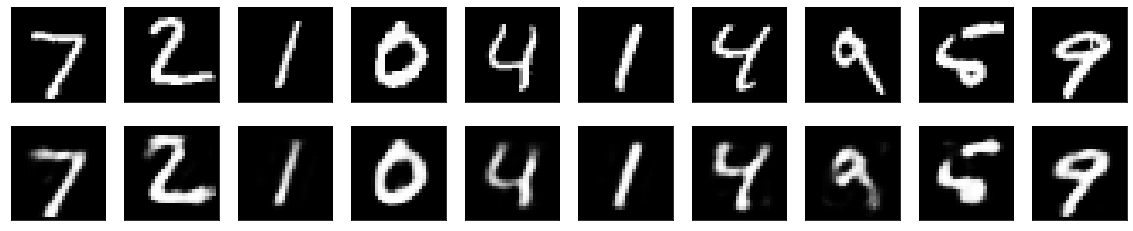

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
